# Computing the Lyapunov exponent

In this notebook, we compute the 

In [1]:
# ---------------------------------------- CELL: 1 ----------------------------------------
# -----------------------------------------------------------------------------------------



# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                               MODULE IMPORTS AND PATH CONFIGURATION
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import os
from numba import set_num_threads, get_num_threads
import pickle
import copy
import numpy as np
from tqdm import tqdm
import pandas as pd
from time import time
from datetime import datetime
from scipy.optimize import curve_fit


from matplotlib import pyplot as plt, rc
#import matplotlib.pyplot as plt
#from matplotlib import rc

import sys
# Add parent directory to Python path (enables importing modules from ../)
# Required for accessing 'curraun' or other parent-dir packages
# Import curraun and other packages, thus enabling access to its modules
sys.path.append('..')  
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




# =========================================================================================================== 
# ======================================== Environment Configuration ========================================
Option_Computation_device   =   2     
Option_GPU_ID               =  "2, 3"  
Option_CPU_NumberofThreads  =   8
# Set the computation device for running the code     
# Initialization of the computation device in the module: numba_target.py              
# 1 : GPU (CUDA : Compute Unified Device Architecture)
# 2 : CPU (Numba)
# 3 : Python
# Set to the GPU ID you want to use GPU (Computation_device = 1),   check with `nvidia-smi` command,   Comma-separated GPU device IDs
# Set the Option_NumberofThreads_CPU for parallelization on CPU

Option_Gauge_group = 2
# Set the gauge group for the Glasma simulation
# Initialization of the gauge group in the module: su.py
# 2 : SU(2)
# 3 : SU(3)
# 4 : SU(2) Complex

Option_Precision_mode = 2 
# Set the precision mode of variable for the Glasma simulation         
# Initialization of the precision mode in th module: energy.py
# 1 : Single precision (float32)
# 2 : Double precision (float64)



# Dictionary for Environment variables
Environment_variables = {
    "Computation_device":           Option_Computation_device,
    "GPU_ID":                       Option_GPU_ID,
    "CPU_NumberofThreads":          Option_CPU_NumberofThreads,
    "Gauge_group":                  Option_Gauge_group,
    "Precision_mode":               Option_Precision_mode 
}


# --------------------------------------------------------------------------------------------------------------------
# Import necessary modules from the Modules package and assign aliases for easier access
import Modules.Parameters as Parameters_Module

#Environment_Config = Parameters_Module.Environment_Setup(Environment_variables)
Environment_Config, Gauge_Group_String = Parameters_Module.Environment_Setup(Environment_variables)
# --------------------------------------------------------------------------------------------------------------------

# =========================================================================================================== 
# =========================================================================================================== 






import curraun.core as core
import curraun.mv as mv
from curraun.energy import Energy
#from curraun.lyapunov_19102025 import Lyapunov				# Edited 19.10.2025
from curraun.lyapunov_26102025_with_comments import Lyapunov				# Edited 21.10.2025

import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

#sys.exit()   





Option_Print_Parameters = 0                                     # 0 : Do not print parameters
                                                                # 1 : Print parameters


N_Events  =  3                                                  # Number of events [Dimensionless]    
N_Sheets  =  1                                                  # Number of color sheets


# We compute everything for g²μ = 1 GeV and then rescale the results.
hbarc  =  0.197326                                          # hbar·c [GeV·fm]
g      =  2.0                                               # Coupling constant [Dimensionless]

g2mu   =  1.0                                               # g²μ [GeV]



# Cutoff Scales
mu     =  g2mu / (g**2)                                     # MV model parameter [GeV]
m_IR   =  0.00001                                           # No infrared regulation, except global charge neutrality [Pooja: Check units????????]
m_UV   =  100000.0                                          # UV regulator [GeV]
    
PI              =  np.pi    


# ----------------------------------------------- Lattice Parameters -----------------------------------------------   
Radius_Nucleus  =  67.7 * (hbarc/g2mu)                          # Radius of the nucleus [fm]
Area_Nucleus    =  PI * (Radius_Nucleus**2)                     # Transverse area of the nucleus [fm^2]

L                =  np.sqrt(Area_Nucleus)                   	# Length of the simulation box [fm]
#L                  =  6.4                                     	# Length of the simulation box [fm]
N_T                =  128					                    # Number of transverse lattice points [Dimensionless]


delta_x          =  L / N_T                                 # Lattice spacing [fm]     
a                =  delta_x					                # Lattice spacing [fm] 
# ---------------------------------------------------------------------------------------------------------------------


tau_max_g2mu_Latt  =  400.0					# tau_max * g²mu	(in lattice units [Dimensionless]) 		
								            # 30.0 for N = 4
N_TimeSteps_per_a  =  8						# Number of time steps per lattice spacing			[Dimensionless]




g2mu_a = g2mu * a                                           # g²μ*a  [GeV·fm]
g2mu_L = g2mu * L                                           # g²μ*L  [GeV·fm]

dk  =  2.0*PI / L                                           # Lattice momentum spacing  [fm⁻¹]

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++ Start: Units Conversion ++++++++++++++++++++++++++++++++++++++++++++++++ #
GeVfm_to_Latt         =  1.0/hbarc                      # GeV·fm to lattice units  [GeV·fm)⁻¹]
GeV_to_Latt           =  a/hbarc                        # GeV to lattice units     [GeV⁻¹]
fm_to_Latt            =  1.0/a							# fm to lattice units      [fm⁻¹]

GeVfmInverse_to_Latt  =  hbarc							# (GeV·fm)⁻¹ to lattice units  [GeV·fm]
GeVInverse_to_Latt    =  hbarc/a						# GeV⁻¹ to lattice units       [GeV]
fmInverse_to_Latt     =  a                              # fm⁻¹ to lattice units        [fm]

Latt_to_GeVfm         =  hbarc							# lattice units to GeV·fm  [GeV·fm]
Latt_to_GeV           =  hbarc/a                        # lattice units to GeV     [GeV]
Latt_to_fm    	      =  a                              # lattice units to fm      [fm]

Latt_to_GeVfmInverse  =  1.0/hbarc						# lattice units to (GeV·fm)⁻¹  [GeV·fm)⁻¹]
Latt_to_GeVInverse    =  a/hbarc						# lattice units to GeV⁻¹	   [GeV⁻¹]
Latt_to_fmInverse     =  1.0/a							# lattice units to fm⁻¹		   [fm⁻¹]
# ++++++++++++++++++++++++++++++++++++++++++++++++++ End: Units Conversion +++++++++++++++++++++++++++++++++++++++++++++++++ #
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #


tau_max_g2mu       =  tau_max_g2mu_Latt * Latt_to_GeVfm							# tau_max * g²mu				[GeV·fm]	
tau_max            =  tau_max_g2mu_Latt * (hbarc/g2mu)							# Maximum proper time, tau		[fm]  
tau_max_Latt       =  tau_max * fm_to_Latt										# Maximum proper time, tau		(in lattice units [Dimensionless]) 	


Nmax_TimeSteps    =  int(tau_max_Latt) * N_TimeSteps_per_a						# Total number of time steps involved in simulation	[Dimensionless]
																				# int: Keeps the value as integer

dtau        =  a / N_TimeSteps_per_a                                               # Time step size, dtau   [fm]
dtau_Latt   =  dtau * fm_to_Latt                                                   # Time step size, dtau   (in lattice units [Dimensionless])

d_tau_Latt  =  1 / N_TimeSteps_per_a                                               # Time step size, d_tau  (in lattice units [Dimensionless])
d_tau       =  d_tau_Latt * Latt_to_fm                                             # Time step size, d_tau  [fm]  





# ========================================================================================================================== #
# =========================================== Start: Parameters in Lattice Units =========================================== #

g_Latt      =  g                                            # Coupling constant [Dimensionless]
hbarc_Latt  =  hbarc * GeVfm_to_Latt                        # hbar*c in lattice units [Dimensionless], hbarc_Latt = 1
g2mu_Latt   =   g2mu * GeV_to_Latt
mu_Latt     =     mu * GeV_to_Latt
m_IR_Latt   =   m_IR * GeV_to_Latt
m_UV_Latt   =   m_UV * GeV_to_Latt


Radius_Nucleus_Latt  =  Radius_Nucleus *fm_to_Latt              # Radius of the nucleus (in lattice units [Dimensionless])
Area_Nucleus_Latt    =  Area_Nucleus * (fm_to_Latt**2)          # Transverse area of the nucleus (in lattice units [Dimensionless])

a_Latt = a * fm_to_Latt                                         # Lattice spacing [Dimensionless],   a_latt = 1
L_Latt = L * fm_to_Latt                                         # Length of the simulation box (in lattice units [Dimensionless])

g2mu_a_Latt = g2mu_a * GeVfm_to_Latt                            # g²μ*a (in lattice units [Dimensionless])
g2mu_L_Latt = g2mu_L * GeVfm_to_Latt                            # g²μ*L (in lattice units [Dimensionless])

dk_Latt  =  dk * fmInverse_to_Latt                              # Lattice momentum spacing	[lattice units] [Dimensionless]

# ============================================ End: Parameters in Lattice Units ============================================ #
# ========================================================================================================================== #





# ========================================================================================================================================================================== #
# ======================================================================= Start: Lyapunov Parameters ======================================================================= #
Option_Fluctuations_EL_BL = 1                                           # 1: Include fluctuations in EL
                                                                        # 2: Include fluctuations in BL

Option_Noise_Type = 1                                                   # 0: No noise
                                                                        # 1: Exponential noise
                                                                        # 2: Power-law noise
                                                                        # 3: Independent noise (Theta/Shell function)

Lypnv_alpha  =  0.001                                                   # [Dimensionless]

                              
Option_Noise_Units = 1                                                                                      # 0: Define parameters in physical units, then convert to lattice units
                                                                                                            # 1: Define parameters in lattice units, then convert to physical units    



if(Option_Noise_Units == 0):
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Parameters for Exponential and Power-law Noise: Physical to Lattice Units """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Lypnv_PL_EXP_M_Noise_Scale    =  0.5                                                    # Scaling factor, M_Noise_Scale for the Exponential and Power-Law Noise     [Dimensionless]  
    Lypnv_PL_EXP_M_Noise          =  Lypnv_PL_EXP_M_Noise_Scale * g2mu                      # Noise parameter, M_Noise for Exponential and Power-Law Noise, used in FFT [GeV]         
    Lypnv_PL_EXP_M_Noise_by_g2mu  =  Lypnv_PL_EXP_M_Noise / g2mu                            # M_Noise/g²μ for Exponential and Power-Law Noise, used in FFT              [Dimensionless]

    Lypnv_PL_EXP_M_Noise_Latt          =  Lypnv_PL_EXP_M_Noise * GeV_to_Latt                # Noise parameter, M_Noise for Exponential and Power-Law Noise, used in FFT (in lattice units [Dimensionless])   
    Lypnv_PL_EXP_M_Noise_by_g2mu_Latt  =  Lypnv_PL_EXP_M_Noise_by_g2mu                      # M_Noise/g²μ for Exponential and Power-Law Noise, used in FFT              (in lattice units [Dimensionless])
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Parameters for Independent Noise (Theta function): Physical to Lattice Units """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Lypnv_THETA_K_Scale                =  20.0                                                                   # Scaling factor, K_Scale for the Theta Noise       [Dimensionless]

    Lypnv_THETA_dk_Shell               =  2.0*dk                                                                # Shell thickness, dk_Shell for the Theta Noise     [fm⁻¹]
    Lypnv_THETA_K_Centre               =  Lypnv_THETA_K_Scale * Lypnv_THETA_dk_Shell                            # Centre of the shell, K_Centre for the Theta Noise [fm⁻¹]
    Lypnv_THETA_K_Centre_by_g2mu       =  Lypnv_THETA_K_Centre / g2mu                                           # K_Centre/g²μ for the Theta Noise                  [GeV·fm)⁻¹]

    Lypnv_THETA_dk_Shell_Latt          =  Lypnv_THETA_dk_Shell * fmInverse_to_Latt                              # Shell thickness, dk_Shell for the Theta Noise     (in lattice units [Dimensionless])
    Lypnv_THETA_K_Centre_Latt          =  Lypnv_THETA_K_Centre * fmInverse_to_Latt                              # Centre of the shell, K_Centre for the Theta Noise (in lattice units [Dimensionless]) 
    Lypnv_THETA_K_Centre_by_g2mu_Latt  =  Lypnv_THETA_K_Centre_by_g2mu * GeVfmInverse_to_Latt                   # K_Centre/g²μ for the Theta Noise                  (in lattice units [Dimensionless])    
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""




elif(Option_Noise_Units == 1):
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Parameters for Exponential and Power-law Noise: Lattice to Physical Units """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Lypnv_PL_EXP_M_Noise_by_g2mu_Latt  =  0.5                                                                  # M_Noise/g²μ for Exponential and Power-Law Noise, used in FFT              (in lattice units [Dimensionless])
    Lypnv_PL_EXP_M_Noise_Latt          =  Lypnv_PL_EXP_M_Noise_by_g2mu_Latt * g2mu_Latt                         # Noise parameter, M_Noise for Exponential and Power-Law Noise, used in FFT (in lattice units [Dimensionless])  
    Lypnv_PL_EXP_M_Noise_Scale         =  Lypnv_PL_EXP_M_Noise_Latt / g2mu_Latt                                 # Scaling factor, M_Noise_Scale for the Exponential and Power-Law Noise     [Dimensionless]     

    Lypnv_PL_EXP_M_Noise_by_g2mu       =  Lypnv_PL_EXP_M_Noise_by_g2mu_Latt                                     # M_Noise/g²μ for Exponential and Power-Law Noise, used in FFT              [Dimensionless] 
    Lypnv_PL_EXP_M_Noise               =  Lypnv_PL_EXP_M_Noise_Latt * Latt_to_GeV                               # Noise parameter, M_Noise for Exponential and Power-Law Noise, used in FFT [GeV] 
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Parameters for Independent Noise (Theta function): Lattice to Physical Units """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Lypnv_THETA_K_Centre_by_g2mu_Latt  =  0.12                                                                   # K_Centre/g²μ for the Theta Noise                  (in lattice units [Dimensionless])
    Lypnv_THETA_K_Centre_Latt          =  Lypnv_THETA_K_Centre_by_g2mu_Latt * g2mu_Latt                         # Centre of the shell, K_Centre for the Theta Noise (in lattice units [Dimensionless]) 
    Lypnv_THETA_dk_Shell_Latt          =  2.0*dk_Latt                                                           # Shell thickness, dk_Shell for the Theta Noise     (in lattice units [Dimensionless])    
    Lypnv_THETA_K_Scale                =  Lypnv_THETA_K_Centre_Latt / Lypnv_THETA_dk_Shell_Latt                 # Scaling factor, K_Scale for the Theta Noise       [Dimensionless]

    Lypnv_THETA_K_Centre_by_g2mu       =  Lypnv_THETA_K_Centre_by_g2mu_Latt * Latt_to_GeVfmInverse              # K_Centre/g²μ for the Theta Noise                  [GeV·fm)⁻¹]
    Lypnv_THETA_K_Centre               =  Lypnv_THETA_K_Centre_Latt * Latt_to_fmInverse                         # Centre of the shell, K_Centre for the Theta Noise [fm⁻¹] 
    Lypnv_THETA_dk_Shell               =  Lypnv_THETA_dk_Shell_Latt * Latt_to_fmInverse                         # Shell thickness, dk_Shell for the Theta Noise     [fm⁻¹]           
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""




""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Formatting strings for plotting and filenames """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
L_String          =  f"{L:.2f}".rstrip('0').rstrip('.')
g2mu_String       =  f"{g2mu:.1f}".rstrip('0').rstrip('.')
alpha_String      =  f"{Lypnv_alpha:.6f}".rstrip('0').rstrip('.')

if Option_Noise_Type == 0:
    Noise_Type = "No noise"
    Noise_Type_String = "None"
    Noise_Value_String = f"{1.0:.1f}" 


elif Option_Noise_Type == 1:
    Noise_Type = "Exponential noise"
    Noise_Type_String = "EXP"
    Noise_Value_String = f"{Lypnv_PL_EXP_M_Noise_by_g2mu_Latt:.1f}" 

elif Option_Noise_Type == 2:
    Noise_Type = "Power-law noise"
    Noise_Type_String = "PL"
    Noise_Value_String = f"{Lypnv_PL_EXP_M_Noise_by_g2mu_Latt:.1f}" 

elif Option_Noise_Type == 3:
    Noise_Type = "Independent noise, Theta/Shell function"
    Noise_Type_String = "THETA"
    Noise_Value_String = f"{Lypnv_THETA_K_Centre_by_g2mu_Latt:.1f}" 
   
else:
    print("\nError: Option_Noise_Type not recognized")
    sys.exit(1)
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# ======================================================================== End: Lyapunov Parameters ======================================================================== #
# ========================================================================================================================================================================== #

if Option_Print_Parameters == 1:
    print("\n\n\nHere are the parameters to be used for Glasma simulation: \n")

    print("No. of events, N_Events       = ", N_Events, "\n")

    print(" ================================================================================================ ")
    print(" ============================== Conversion Factors (Mutiplicative) ============================== ")
    print(f"GeV·fm to lattice units      = {GeVfm_to_Latt:12.6f}")
    print(f"GeV to lattice units         = {GeV_to_Latt:12.6f}")
    print(f"fm to lattice units          = {fm_to_Latt:12.6f}\n")
    print(f"(GeV·fm)⁻¹ to lattice units  = {GeVfmInverse_to_Latt:12.6f}")
    print(f"GeV⁻¹ to lattice units       = {GeVInverse_to_Latt:12.6f}")
    print(f"fm⁻¹ to lattice units        = {fmInverse_to_Latt:12.6f}\n")

    print(f"lattice units to GeV·fm      = {Latt_to_GeVfm:12.6f}")
    print(f"lattice units to GeV         = {Latt_to_GeV:12.6f}")
    print(f"lattice units to fm          = {Latt_to_fm:12.6f}\n")
    print(f"lattice units to (GeV·fm)⁻¹  = {Latt_to_GeVfmInverse:12.6f}")
    print(f"lattice units to GeV⁻¹       = {Latt_to_GeVInverse:12.6f}")
    print(f"lattice units to fm⁻¹        = {Latt_to_fmInverse:12.6f}")
    print(" ================================================================================================ ")
    print(" ================================================================================================\n ")


    print(f"hbarc                = {hbarc:12.6f} GeV·fm          = {hbarc_Latt:12.6f} (in lattice units [Dimensionless])")
    print(f"g²μ                  = {g2mu:12.6f} GeV             = {g2mu_Latt:12.6f} (in lattice units [Dimensionless])\n")
    print(f"Coupling constant, g = {g:12.6f} [Dimensionless]")
    print(f"μ                    = {mu:12.6f} GeV             =   {mu_Latt:12.6f} (in lattice units [Dimensionless])")
    print(f"m_IR                 = {m_IR:12.6f} GeV             =   {m_IR_Latt:12.6f} (in lattice units [Dimensionless])")
    print(f"m_UV                 = {m_UV:12.6f} GeV            =   {m_UV_Latt:12.6f} (in lattice units [Dimensionless])\n")

    print(f"PI                   = {PI:12.6f}\n")

    print(f"Radius of the nucleus, Radius_Nucleus         = {Radius_Nucleus:12.6f} fm      =   {Radius_Nucleus_Latt:12.6f} (in lattice units [Dimensionless])")  
    print(f"Transverse area of the nucleus, Area_Nucleus  = {Area_Nucleus:12.6f} fm^2    =   {Area_Nucleus_Latt:12.6f} (in lattice units [Dimensionless])\n")

    print(f"Number of lattice points, Nₜ      = {N_T:12d}")
    print(f"Length of the simulation box, L    = {L:12.6f} fm    =   {L_Latt:8.2f} (in lattice units [Dimensionless])")
    print(f"Lattice spacing, delta_x           = {a:12.6f} fm    =   {a_Latt:8.2f} (in lattice units [Dimensionless])\n")

    print(f"g²μ.a  = {g2mu*a:12.6f} GeV·fm     =   {g2mu_a_Latt:12.6f} (in lattice units [Dimensionless])")
    print(f"g²μ.L  = {g2mu*L:12.6f} GeV·fm     =   {g2mu_L_Latt:12.6f} (in lattice units [Dimensionless])\n")

    print(f"Lattice momentum spacing, dk  = {dk:12.6f} fm⁻¹   = {dk_Latt:12.8f} (in lattice units [Dimensionless])\n")


    print(f"Maximum proper time, τₘₐₓ·g²μ                       = {tau_max_g2mu:12.6f} GeV·fm            = {tau_max_g2mu_Latt:12.6f} (in lattice units [Dimensionless])")
    print(f"Maximum proper time, τₘₐₓ                           = {tau_max:12.6f} fm                = {tau_max_Latt:12.6f} (in lattice units [Dimensionless])\n")
    print(f"Time steps per lattice spacing, N_TimeSteps_per_a   = {N_TimeSteps_per_a:12d} [Dimensionless]")
    print(f"Total number of time steps, N_TimeStepsₘₐₓ          = {Nmax_TimeSteps:12d} [Dimensionless]\n")

    print(f"Time step size, dτ                                  = {dtau:12.6f} fm         =   {dtau_Latt:12.6f} (in lattice units [Dimensionless])")
    print(f"Time step size, d_τ                                 = {d_tau:12.6f} fm         =   {d_tau_Latt:12.6f} (in lattice units [Dimensionless])\n")

    print(" ================================================================================================ ")
    print(" ====================================== Lyapunov Parameters ===================================== ")
    print(f"Noise Type                             = {Noise_Type_String:>12s}")
    print(f"Lyapunov perturbation, alpha           = {Lypnv_alpha:12.6f} [Dimensionless]\n")

    print(f"PL/EXP Noise scale factor, M_Scale     = {Lypnv_PL_EXP_M_Noise_Scale:12.6f} [Dimensionless]")
    print(f"PL/EXP Noise parameter,    M_Noise     = {Lypnv_PL_EXP_M_Noise:12.6f} GeV              = {Lypnv_PL_EXP_M_Noise_Latt:12.6f} (in lattice units [Dimensionless])")
    print(f"PL/EXP M_Noise/g²μ                     = {Lypnv_PL_EXP_M_Noise_by_g2mu:12.6f} [Dimensionless]  = {Lypnv_PL_EXP_M_Noise_by_g2mu_Latt:12.6f} (in lattice units [Dimensionless])\n")

    
    print(f"THETA Noise scale factor, K_Scale      = {Lypnv_THETA_K_Scale:12.6f} [Dimensionless]")
    print(f"THETA Shell thickness,   dk_Shell      = {Lypnv_THETA_dk_Shell:12.6f} fm⁻¹             = {Lypnv_THETA_dk_Shell_Latt:12.6f} (in lattice units [Dimensionless])")
    print(f"THETA Shell center,      K_Centre      = {Lypnv_THETA_K_Centre:12.6f} fm⁻¹             = {Lypnv_THETA_K_Centre_Latt:12.6f} (in lattice units [Dimensionless])")
    print(f"THETA K_Centre/g²μ                     = {Lypnv_THETA_K_Centre_by_g2mu:12.6f} (GeV·fm)⁻¹       = {Lypnv_THETA_K_Centre_by_g2mu_Latt:12.6f} (in lattice units [Dimensionless])\n")  

    print(f"Noise Type String                      = {Noise_Type_String:>12s}")
    print(f"Noise Value String                     = {Noise_Value_String:>12s}")
    print(f"alpha String                           = {alpha_String:>12s}")
    print(f"Lattice Length String                  = {L_String:>12s}")
    print(f"g²μ String                             = {g2mu_String:>12s} \n")
    print(" ================================================================================================ ")
    print(" ================================================================================================\n ")




""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Start: Dictionary for Glasma Parameters """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Glasma_Parameters_Dictionary = {    
    'N_Events'                 : N_Events,                                # Number of events [Dimensionless]
    'N_Sheets'                 : N_Sheets,                                # Number of color sheets [Dimensionless]

    'L'                        : L,                                       # Transverse size of lattice [fm]
    'L_Latt'                   : L_Latt,                                  # Transverse size of lattice [lattice units]

    'N_T'                      : N_T,                                     # Number of lattice points [Dimensionless]

    'a'                        : a,                                       # Lattice spacing [fm]
    'a_Latt'                   : a_Latt,                                  # Lattice spacing [lattice units]

    'dk'                       : dk,                                      # Lattice momentum spacing [fm⁻¹]
    'dk_Latt'                  : dk_Latt,                                 # Lattice momentum spacing [lattice units]

    'g'                        : g,                                       # YM coupling constant [Dimensionless]
    'g2mu'                     : g2mu,                                    # g²μ [GeV]
    'g2mu_Latt'                : g2mu_Latt,                               # g²μ [lattice units]
    'g2mu_a'                   : g2mu_a,                                  # g²μ·a [GeV·fm]
    'g2mu_a_Latt'              : g2mu_a_Latt,                             # g²μ·a [lattice units]
    'g2mu_L'                   : g2mu_L,                                  # g²μ·L [GeV·fm]
    'g2mu_L_Latt'              : g2mu_L_Latt,                             # g²μ·L [lattice units]

    'mu'                       : mu,                                      # MV model parameter [GeV]
    'mu_Latt'                  : mu_Latt,                                 # MV model parameter [lattice units]

    'M_IR'                     : m_IR,                                    # IR regulator [GeV]
    'm_IR_Latt'                : m_IR_Latt,                               # IR regulator [lattice units]
   
    'M_UV'                     : m_UV,                                    # UV regulator [GeV]
    'M_UV_Latt'                : m_UV_Latt,                               # UV regulator [lattice units]


    'tau_max'                  : tau_max,                                 # Maximum proper time, τₘₐₓ [fm]
    'tau_max_Latt'             : tau_max_Latt,                            # Maximum proper time, τₘₐₓ [lattice units]
    'tau_max_g2mu'             : tau_max_g2mu,                            # τₘₐₓ·g²μ [GeV·fm]
    'tau_max_g2mu_Latt'        : tau_max_g2mu_Latt,                       # τₘₐₓ·g²μ [lattice units]

    'N_t_a'                    : N_TimeSteps_per_a,                       # Time steps per lattice spacing [Dimensionless]
    'N_t_max'                  : Nmax_TimeSteps,                          # Total number of time steps [Dimensionless]

    'dtau'                     : dtau,                                    # Time step size, dτ  [fm]
    'dtau_Latt'                : dtau_Latt,                               # Time step size, dτ  [lattice units]
    'd_tau'                    : d_tau,                                   # Time step size, d_τ [fm]
    'd_tau_Latt'               : d_tau_Latt,                              # Time step size, d_τ [lattice units]

    'Ly_Option_Noise_Type'     : Option_Noise_Type,                       # Noise type option [Dimensionless]
    'Ly_alpha'                 : Lypnv_alpha,                             # Lyapunov perturbation parameter [Dimensionless]

    'Ly_M_Noise_Scale'         : Lypnv_PL_EXP_M_Noise_Scale,              # Noise scale factor [Dimensionless]

    'Ly_M_noise_phy'           : Lypnv_PL_EXP_M_Noise,                    # Noise parameter for FFT [GeV]
    'Ly_M_noise_latt'          : Lypnv_PL_EXP_M_Noise_Latt,               # Noise parameter for FFT [lattice units]

    'Ly_M_Noise_by_g2mu'       : Lypnv_PL_EXP_M_Noise_by_g2mu,            # M_Noise/g²μ [Dimensionless]
    'Ly_M_Noise_by_g2mu_latt'  : Lypnv_PL_EXP_M_Noise_by_g2mu_Latt,       # M_Noise/g²μ [lattice units]

    'Ly_K_Scale'               : Lypnv_THETA_K_Scale,                     # K scale factor [Dimensionless]

    'Ly_K_centre_phy'          : Lypnv_THETA_K_Centre,                    # Center of the shell [fm⁻¹]
    'Ly_K_centre_latt'         : Lypnv_THETA_K_Centre_Latt,               # Center of the shell [lattice units]

    'Ly_dk_shell_phy'          : Lypnv_THETA_dk_Shell,                    # Shell thickness [fm⁻¹]
    'Ly_dk_shell_latt'         : Lypnv_THETA_dk_Shell_Latt,               # Shell thickness [lattice units]
    
    'Ly_K_Centre_by_g2mu'      : Lypnv_THETA_K_Centre_by_g2mu,            # K_Centre/g²μ [(GeV·fm)⁻¹]
    'Ly_K_Centre_by_g2mu_latt' : Lypnv_THETA_K_Centre_by_g2mu_Latt,       # K_Centre/g²μ [lattice units]


    'GeVfm_to_Latt'            : GeVfm_to_Latt,                           # GeV·fm to lattice units  [GeV·fm)⁻¹]
    'GeV_to_Latt'              : GeV_to_Latt,                             # GeV to lattice units     [GeV⁻¹]
    'fm_to_Latt'               : fm_to_Latt,                              # fm to lattice units      [fm⁻¹]

    'GeVfmInverse_to_Latt'     : GeVfmInverse_to_Latt,                    # (GeV·fm)⁻¹ to lattice units [GeV·fm]
    'GeVInverse_to_Latt'       : GeVInverse_to_Latt,                        # GeV⁻¹ to lattice units    [GeV]
    'fmInverse_to_Latt'        : fmInverse_to_Latt,                       # fm⁻¹ to lattice units       [fm]

    'Latt_to_GeVfm'            : Latt_to_GeVfm,                           # lattice units to GeV·fm  [GeV·fm]
    'Latt_to_GeV'              : Latt_to_GeV,                             # lattice units to GeV     [GeV]
    'Latt_to_fm'               : Latt_to_fm,                              # lattice units to fm      [fm]

    'Latt_to_GeVfmInverse'     : Latt_to_GeVfmInverse,                    # lattice units to (GeV·fm)⁻¹ [GeV·fm)⁻¹]
    'Latt_to_GeVInverse'       : Latt_to_GeVInverse,                        # lattice units to GeV⁻¹    [GeV⁻¹]
    'Latt_to_fmInverse'        : Latt_to_fmInverse,                       # lattice units to fm⁻¹       [fm⁻¹]  
}

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" End: Dictionary for Glasma Parameters """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------
start_time = datetime.now()                                             # datetime.now() gets the current date and time from your system. 
                                                                        # It returns a datetime object (which contains year, month, day, hour, minute, second, etc.).
                                                                        # Next, store that value in the variable present_time.
start_time_formatted = start_time.strftime("%d-%m-%Y %H:%M:%S")     # .strftime() means “string format time” 
                                                                        # It convertS a datetime object into a string, in your given format.
print("\n\n\nHello, the start time is:   ", start_time_formatted, "\n")
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------




def compute(p):    
    
    output = {}                                                                                     # Output dictionary to store output data

    # output["energy"], output["pL"] , output["pT"]  = [], [], []
    # output["EL"], output["BL"], output["ET"], output["BT"] = [], [], [], []

    # output["energyp"], output["pLp"] , output["pTp"]  = [], [], []
    # output["ELp"], output["BLp"], output["ETp"], output["BTp"] = [], [], [], []


    output["Tr_ELdiff2"] = []
    output["Tr_ELdiff2_Mean"] = []
    output["Tr_ELdiff2_Variance"] = []
    output["Tr_ELdiff2_StD"] = []
    output["Tr_ELdiff2_Error"] = []

    output["Ratio_Tr_ELdiff2_Tr_EL2"] = []
    output["Ratio_Tr_ELdiff2_Tr_EL2_Mean"] = []
    output["Ratio_Tr_ELdiff2_Tr_EL2_Variance"] = []
    output["Ratio_Tr_ELdiff2_Tr_EL2_StD"] = []
    output["Ratio_Tr_ELdiff2_Tr_EL2_Error"] = []

    output["Tr_ELdiff2_by_alpha2"] = []
    output["Tr_ELdiff2_by_alpha2_Mean"] = []
    output["Tr_ELdiff2_by_alpha2_Variance"] = []
    output["Tr_ELdiff2_by_alpha2_StD"] = []
    output["Tr_ELdiff2_by_alpha2_Error"] = []

    output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2"] = []
    output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2_Mean"] = []
    output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2_Variance"] = []
    output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2_StD"] = []
    output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2_Error"] = []



    output["Tr_BLdiff2"] = []
    output["Tr_BLdiff2_Mean"] = []
    output["Tr_BLdiff2_Variance"] = []
    output["Tr_BLdiff2_StD"] = []
    output["Tr_BLdiff2_Error"] = []

    output["Ratio_Tr_BLdiff2_Tr_BL2"] = []
    output["Ratio_Tr_BLdiff2_Tr_BL2_Mean"] = []
    output["Ratio_Tr_BLdiff2_Tr_BL2_Variance"] = [] 
    output["Ratio_Tr_BLdiff2_Tr_BL2_StD"] = []
    output["Ratio_Tr_BLdiff2_Tr_BL2_Error"] = []

    output["Tr_BLdiff2_by_alpha2"] = []
    output["Tr_BLdiff2_by_alpha2_Mean"] = []
    output["Tr_BLdiff2_by_alpha2_Variance"] = []
    output["Tr_BLdiff2_by_alpha2_StD"] = []
    output["Tr_BLdiff2_by_alpha2_Error"] = []

    output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2"] = []
    output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2_Mean"] = []
    output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2_Variance"] = []
    output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2_StD"] = []
    output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2_Error"] = []


    #  --------------  START: Should be removed later --------------
    # output["ratio_dif"]          = []
    # output["ratio_dif_variance"] = []
    # output["ratio_dif_std"]      = []
    # output["ratio_dif_error"]    = []

    # output["ratio_difalpha2"]          = []
    # output["ratio_difalpha2_variance"] = []
    # output["ratio_difalpha2_std"]      = []
    # output["ratio_difalpha2_error"]    = []
    #  --------------  END: Should be removed later --------------
    

    start_tau = 1
    
    for i_Event in range(N_Events):                                                                                      
        print("\nSimulating event {} of {}".format(i_Event +1, N_Events), "at  ", datetime.now().strftime("%d-%m-%Y %H:%M:%S")  ) 

        # Initialization
        s = core.Simulation(N_T, dtau_Latt, g)

        Va = mv.wilson( s,   mu = mu_Latt,   m = m_IR_Latt,   uv = m_UV_Latt,  num_sheets = N_Sheets )
        Vb = mv.wilson( s,   mu = mu_Latt,   m = m_IR_Latt,   uv = m_UV_Latt,  num_sheets = N_Sheets )        
        initial.init(s, Va, Vb)

        en = Energy(s)                                              # initialize energy computation

        

        # ************************* Start: Lyapunov Exponents  *************************
        sprime = copy.deepcopy(s)                                   # copy of s        
        enp = Energy(sprime)                                        # ed for sprime        
        ly = Lyapunov(s, sprime)                                    # initialize Lyapunov computation        
        

        alpha     =  p["Ly_alpha"]        
        m_noise   =  p["Ly_M_noise_latt"]                                       # Added 23.04.2025
        K_centre  =  p["Ly_K_centre_latt"]                                      # Added 10.09.2025
        dk        =  p["Ly_dk_shell_latt"]                                      # Added 10.09.2025

        """        
        print("m_noise        =", m_noise)                  
        print("alpha          =", alpha)             
        print("K_centre      =", K_centre)             
        print("dk            =", dk)         
        """
 

        if(Option_Fluctuations_EL_BL == 1):
            ly.change_EL(Option_Noise_Type, alpha, m_noise, K_centre, dk)                                   # Added 10.09.2025
        elif(Option_Fluctuations_EL_BL == 2):
            ly.change_Ui(Option_Noise_Type, alpha, m_noise, K_centre, dk)                                   # Added 10.09.2025
        else:
            print("\nError: Option_Fluctuations_EL_BL not recognized")
            sys.exit(1)
        # ************************* End: Lyapunov Exponents  *************************


        energy,  pL,  pT,  EL,  BL,  ET,  BT  = [], [], [], [], [], [], []
        energyp, pLp, pTp, ELp, BLp, ETp, BTp = [], [], [], [], [], [], []
        	
        
        taus                          = []                                                                               # taus: An empty list that will be used to store time step number during the simulation                            
        
        Tr_ELdiff2_List               = []
        Ratio_Tr_ELdiff2_Tr_EL2_List  = []

        Tr_BLdiff2_List               = []
        Ratio_Tr_BLdiff2_Tr_BL2_List  = []

        #ratio_dif_list               = []



        # !!!!!!!!!!!!!!!!!!!!!! For GPU computation !!!!!!!!!!!!!!!!!!!!!!
        if use_cuda:

            s.copy_to_device()
            meminfo = cuda.current_context().get_memory_info()
            # print("CUDA free memory: {:.2f} GB of {:.2f} GB.".format(meminfo[0] / 1024 ** 3, meminfo[1] / 1024 ** 3))
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


        for i_tau in tqdm(range(Nmax_TimeSteps)):                   # Time evolution loop    : i_tau = 0, 1, 2, ..., Nmax_TimeSteps-1   
        #for i_tau in range(Nmax_TimeSteps):                                                                                                                                                                   
       
            #print("i_tau =", i_tau, "of", Nmax_TimeSteps, (i_tau+1) * dtau )

            core.evolve_leapfrog(s)            
            core.evolve_leapfrog(sprime)                                            # evole sprime copy of s with el changed

            if i_tau >= start_tau:
                units = Latt_to_GeV ** 2 / (s.g ** 2)                               # Unit factors (GeV³)

                
                Nc = core.su.NC                                                     # Color factors (for quarks)
                f = 2 * s.g ** 2 / (2 * Nc)


                """
                # Energy density calculation for s and sprime
                en.compute()
                enp.compute()

                Latt_to_GeV4        =  Latt_to_GeV ** 4                             # lattice units to GeV⁴
                Latt_to_GeV_by_fm3  =  Latt_to_GeV4 / (hbarc ** 3)                  # lattice units to GeV/fm³

                # unit factors (GeV^3) 
                EL.append(en.EL_mean * Latt_to_GeV4)
                BL.append(en.BL_mean * Latt_to_GeV4)
                ET.append(en.ET_mean * Latt_to_GeV4)
                BT.append(en.BT_mean * Latt_to_GeV4)

                ELp.append(enp.EL_mean * Latt_to_GeV4)
                BLp.append(enp.BL_mean * Latt_to_GeV4)
                ETp.append(enp.ET_mean * Latt_to_GeV4)
                BTp.append(enp.BT_mean * Latt_to_GeV4)

                
                energy.append(en.energy_density * Latt_to_GeV_by_fm3)               # Unit factors (GeV/fm³)
                pL.append(en.pL * Latt_to_GeV_by_fm3)
                pT.append(en.pT * Latt_to_GeV_by_fm3)

                energyp.append(enp.energy_density * Latt_to_GeV_by_fm3)
                pLp.append(enp.pL * Latt_to_GeV_by_fm3)
                pTp.append(enp.pT * Latt_to_GeV_by_fm3)
                """


                if(Option_Fluctuations_EL_BL == 1, 2):
                    ly.Measure_EL()
                    ly.Measure_BL()
                    #ratio_dif_list.append(ly.Ratio_Trace_BLdiff2_Trace_BL2)

                    Tr_ELdiff2_List.append(ly.Trace_ELdiff2)
                    Ratio_Tr_ELdiff2_Tr_EL2_List.append(ly.Ratio_Trace_ELdiff2_Trace_EL2)

                    Tr_BLdiff2_List.append(ly.Trace_BLdiff2)
                    Ratio_Tr_BLdiff2_Tr_BL2_List.append(ly.Ratio_Trace_BLdiff2_Trace_BL2)


                else:
                    print("\nError: Option_Fluctuations_EL_BL not recognized")
                    sys.exit(1)


                taus.append(i_tau)

        """
        energy = np.array(energy)                                                                               # Converts the Python list energy to a NumPy array
                                                                                                                # List  version look like: [1,  2,  3,  4]
                                                                                                                # NumPy version look like: [1  2  3  4] (no commas)
        
        EL = np.array(EL)                                                                                     # Converts the Python list EL to a NumPy array
        ET = np.array(ET)                                                                                     # Converts the Python list ET to a NumPy array
        BL = np.array(BL)                                                                                     # Converts the Python list BL to a NumPy array
        BT = np.array(BT)                                                                                     # Converts the Python list BT to a NumPy array
        pL = np.array(pL)                                                                                     # Converts the Python list pL to a NumPy array
        pT = np.array(pT)                                                                                     # Converts the Python list pT to a NumPy array

        energyp = np.array(energyp)
        ELp = np.array(ELp)                                                                                   # Converts the Python list ELp to a NumPy array
        ETp = np.array(ETp)                                                                                   # Converts the Python list ETp to a NumPy array
        BLp = np.array(BLp)                                                                                   # Converts the Python list BLp to a NumPy array
        BTp = np.array(BTp)                                                                                   # Converts the Python list BTp to a NumPy array
        pLp = np.array(pLp)                                                                                   # Converts the Python list pLp to a NumPy array
        pTp = np.array(pTp)                                                                                   # Converts the Python list pTp to a NumPy array
        

        #EL, BL, ET, BT = np.array(EL), np.array(BL), np.array(ET), np.array(BT)
        #ELp, BLp, ETp, BTp = np.array(ELp), np.array(BLp), np.array(ETp), np.array(BTp)

        #pL, pT = np.array(pL), np.array(pT)
        #pLp, pTp = np.array(pLp), np.array(pTp)


        output["energy"].append(energy)

        output["EL"].append(EL)
        output["BL"].append(BL)
        output["ET"].append(ET)
        output["BT"].append(BT)

        output["pL"].append(pL)
        output["pT"].append(pT)

        output["energyp"].append(energyp)

        output["ELp"].append(ELp)
        output["BLp"].append(BLp)
        output["ETp"].append(ETp)
        output["BTp"].append(BTp)

        output["pLp"].append(pLp)
        output["pTp"].append(pTp)


        """

        # ************************* Lyapunov Exponents  *************************      

        Tr_ELdiff2_Array               =  np.array(Tr_ELdiff2_List)
        Ratio_Tr_ELdiff2_Tr_EL2_Array  =  np.array(Ratio_Tr_ELdiff2_Tr_EL2_List)

        Tr_BLdiff2_Array               =  np.array(Tr_BLdiff2_List)
        Ratio_Tr_BLdiff2_Tr_BL2_Array  =  np.array(Ratio_Tr_BLdiff2_Tr_BL2_List)


        #ratio_dif_array = np.array(ratio_dif_list)

        # output["ratio_dif"].append(ratio_dif_array)
        # output["ratio_difalpha2"].append(ratio_dif_array/(alpha**2.0))        # Computed variance of the ratio_dif


        output["Tr_ELdiff2"].append(Tr_ELdiff2_Array)
        output["Ratio_Tr_ELdiff2_Tr_EL2"].append(Ratio_Tr_ELdiff2_Tr_EL2_Array)

        output["Tr_ELdiff2_by_alpha2"].append(Tr_ELdiff2_Array/(alpha**2.0))
        output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2"].append(Ratio_Tr_ELdiff2_Tr_EL2_Array/(alpha**2.0))

        output["Tr_BLdiff2"].append(Tr_BLdiff2_Array)
        output["Ratio_Tr_BLdiff2_Tr_BL2"].append(Ratio_Tr_BLdiff2_Tr_BL2_Array)

        output["Tr_BLdiff2_by_alpha2"].append(Tr_BLdiff2_Array/(alpha**2.0))
        output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2"].append(Ratio_Tr_BLdiff2_Tr_BL2_Array/(alpha**2.0))

        # ************************* Lyapunov Exponents  *************************

    # perform average over events
    
    # also add standard deviations

    # output["energy_std"] = np.std(np.array(output["energy"]), axis=0)    
    # output["EL_std"] = np.std(np.array(output["EL"]), axis=0)
    # output["BL_std"] = np.std(np.array(output["BL"]), axis=0)
    # output["ET_std"] = np.std(np.array(output["ET"]), axis=0)
    # output["BT_std"] = np.std(np.array(output["BT"]), axis=0)    
    # output["pL_std"] = np.std(np.array(output["pL"]), axis=0)
    # output["pT_std"] = np.std(np.array(output["pT"]), axis=0)
    
    """
    # compute means
    output["energy"] = np.mean(np.array(output["energy"]), axis=0)
    
    output["EL"] = np.mean(np.array(output["EL"]), axis=0)
    output["BL"] = np.mean(np.array(output["BL"]), axis=0)
    output["ET"] = np.mean(np.array(output["ET"]), axis=0)
    output["BT"] = np.mean(np.array(output["BT"]), axis=0)
    
    output["pL"] = np.mean(np.array(output["pL"]), axis=0)
    output["pT"] = np.mean(np.array(output["pT"]), axis=0)


    output["energyp"] = np.mean(np.array(output["energyp"]), axis=0)

    output["ELp"] = np.mean(np.array(output["ELp"]), axis=0)
    output["BLp"] = np.mean(np.array(output["BLp"]), axis=0)
    output["ETp"] = np.mean(np.array(output["ETp"]), axis=0)
    output["BTp"] = np.mean(np.array(output["BTp"]), axis=0)
    
    output["pLp"] = np.mean(np.array(output["pLp"]), axis=0)
    output["pTp"] = np.mean(np.array(output["pTp"]), axis=0)

    """



    # ************************* Lyapunov Exponents  *************************
    output["Tr_ELdiff2_Mean"]     = np.mean(np.array(output["Tr_ELdiff2"]), axis=0)
    output["Tr_ELdiff2_Variance"] = np.var(np.array(output["Tr_ELdiff2"]), axis=0)        # Calculate variance of Tr_ELdiff2
    output["Tr_ELdiff2_StD"]      = np.std(np.array(output["Tr_ELdiff2"]), axis=0)        # Calculate standard deviation of  Tr_ELdiff2
    output["Tr_ELdiff2_Error"]    = np.std(np.array(output["Tr_ELdiff2"]), axis=0)/np.sqrt(N_Events)      # Calculate Error of Tr_ELdiff2

    output["Tr_ELdiff2_by_alpha2_Mean"]     = np.mean(np.array(output["Tr_ELdiff2_by_alpha2"]), axis=0)
    output["Tr_ELdiff2_by_alpha2_Variance"] = np.var(np.array(output["Tr_ELdiff2_by_alpha2"]), axis=0)    
    output["Tr_ELdiff2_by_alpha2_StD"]      = np.std(np.array(output["Tr_ELdiff2_by_alpha2"]), axis=0)    
    output["Tr_ELdiff2_by_alpha2_Error"]    = np.std(np.array(output["Tr_ELdiff2_by_alpha2"]), axis=0)/np.sqrt(N_Events)    

    output["Ratio_Tr_ELdiff2_Tr_EL2_Mean"]     = np.mean(np.array(output["Ratio_Tr_ELdiff2_Tr_EL2"]), axis=0)
    output["Ratio_Tr_ELdiff2_Tr_EL2_Variance"] = np.var(np.array(output["Ratio_Tr_ELdiff2_Tr_EL2"]), axis=0)    
    output["Ratio_Tr_ELdiff2_Tr_EL2_StD"]      = np.std(np.array(output["Ratio_Tr_ELdiff2_Tr_EL2"]), axis=0)
    output["Ratio_Tr_ELdiff2_Tr_EL2_Error"]    = np.std(np.array(output["Ratio_Tr_ELdiff2_Tr_EL2"]), axis=0)/np.sqrt(N_Events)

    output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2_Mean"]     = np.mean(np.array(output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2"]), axis=0)
    output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2_Variance"] = np.var(np.array(output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2"]), axis=0)    
    output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2_StD"]      = np.std(np.array(output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2"]), axis=0)    
    output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2_Error"]    = np.std(np.array(output["Ratio_Tr_ELdiff2_Tr_EL2_by_alpha2"]), axis=0)/np.sqrt(N_Events) 


    output["Tr_BLdiff2_Mean"]     = np.mean(np.array(output["Tr_BLdiff2"]), axis=0)
    output["Tr_BLdiff2_Variance"] = np.var(np.array(output["Tr_BLdiff2"]), axis=0)        # Calculate variance of Tr_BLdiff2
    output["Tr_BLdiff2_StD"]      = np.std(np.array(output["Tr_BLdiff2"]), axis=0)        # Calculate standard deviation of  Tr_BLdiff2
    output["Tr_BLdiff2_Error"]    = np.std(np.array(output["Tr_BLdiff2"]), axis=0)/np.sqrt(N_Events)      # Calculate Error of Tr_BLdiff2   

    output["Tr_BLdiff2_by_alpha2_Mean"]     = np.mean(np.array(output["Tr_BLdiff2_by_alpha2"]), axis=0)
    output["Tr_BLdiff2_by_alpha2_Variance"] = np.var(np.array(output["Tr_BLdiff2_by_alpha2"]), axis=0)    
    output["Tr_BLdiff2_by_alpha2_StD"]      = np.std(np.array(output["Tr_BLdiff2_by_alpha2"]), axis=0)    
    output["Tr_BLdiff2_by_alpha2_Error"]    = np.std(np.array(output["Tr_BLdiff2_by_alpha2"]), axis=0)/np.sqrt(N_Events)

    output["Ratio_Tr_BLdiff2_Tr_BL2_Mean"]     = np.mean(np.array(output["Ratio_Tr_BLdiff2_Tr_BL2"]), axis=0)
    output["Ratio_Tr_BLdiff2_Tr_BL2_Variance"] = np.var(np.array(output["Ratio_Tr_BLdiff2_Tr_BL2"]), axis=0)    
    output["Ratio_Tr_BLdiff2_Tr_BL2_StD"]      = np.std(np.array(output["Ratio_Tr_BLdiff2_Tr_BL2"]), axis=0)
    output["Ratio_Tr_BLdiff2_Tr_BL2_Error"]    = np.std(np.array(output["Ratio_Tr_BLdiff2_Tr_BL2"]), axis=0)/np.sqrt(N_Events)

    output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2_Mean"]     = np.mean(np.array(output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2"]), axis=0)
    output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2_Variance"] = np.var(np.array(output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2"]), axis=0)    
    output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2_StD"]     = np.std(np.array(output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2"]), axis=0) 
    output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2_Error"]    = np.std(np.array(output["Ratio_Tr_BLdiff2_Tr_BL2_by_alpha2"]), axis=0)/np.sqrt(N_Events)  





    # ************************* OLD: Lyapunov Exponents  *************************

    # output["ratio_dif_variance"] = np.var(np.array(output["ratio_dif"]), axis=0)        # Computed variance of the ratio_dif
    # output["ratio_dif_std"]      = np.std(np.array(output["ratio_dif"]), axis=0)        # Calculate variance and standard deviation of the ratio_dif before calculating mean because otherwise it will be wrong due to file names changed
    # output["ratio_dif_error"   ] = np.std(np.array(output["ratio_dif"]), axis=0)/np.sqrt(N_Events)      # Error
    # output["ratio_dif"]          = np.mean(np.array(output["ratio_dif"]), axis=0)


    # output["ratio_difalpha2_variance"] = np.var(np.array(output["ratio_difalpha2"]), axis=0)    
    # output["ratio_difalpha2_std"]      = np.std(np.array(output["ratio_difalpha2"]), axis=0)    
    # output["ratio_difalpha2_error"   ] = np.std(np.array(output["ratio_difalpha2"]), axis=0)/np.sqrt(N_Events)    
    # output["ratio_difalpha2"]          = np.mean(np.array(output["ratio_difalpha2"]), axis=0)


    """
    print("\n output[\"ratio_dif\"]          = ", output["ratio_dif"])
    print("\n output[\"ratio_difalpha2\"]          = ", output["ratio_difalpha2"])
   
    print("\n output[\"ratio_dif_variance\"] = ", output["ratio_dif_variance"])
    print("\n output[\"ratio_difalpha2_variance\"] = ", output["ratio_difalpha2_variance"])

    print("\n output[\"ratio_dif_std\"]      = ", output["ratio_dif_std"])
    print("\n output[\"ratio_difalpha2_std\"]      = ", output["ratio_difalpha2_std"])

    print("\n output[\"ratio_dif_error\"]          = ", output["ratio_dif_error"])
    print("\n output[\"ratio_difalpha2_error\"]          = ", output["ratio_difalpha2_error"])  
    """

    #print("\n output[\"energyp\"]  = ", output["energyp"])
    #print("\n output[\"energyp\"]  = ", output["energyp"])

    
    """
    print("\n output[\"ratio_dif\"]          = ", output["ratio_dif"])
    print("\n output[\"ratio_dif_variance\"] = ", output["ratio_dif_variance"])  
    print("\n output[\"ratio_dif_std\"]      = ", output["ratio_dif_std"])
    """
    # ************************* OLD: Lyapunov Exponents  *************************
    

    #print("taus after time loop, taulist: \n", taus)



    i_tau      =  np.array(taus)                                            # Convert the Python list taus to a NumPy array of time steps
                                                                            # taus: [1,  2,  3,  4 ...., Nmax_TimeSteps-1]
                                                                            # i_tau: [1  2  3  4 ....  Nmax_TimeSteps-1] (no commas)

    i_max_tau  =  np.max(i_tau)                                             # Maximum value of time step simulated (Nmax_TimeSteps-1) in the "i_tau" NumPy array
    #i_max_tau  =  np.max(taus)                                             # Maximum value of time step simulated (Nmax_TimeSteps-1) in the "taus" list

    delta_tau   = p["tau_max"] / i_max_tau                                  # Proper time step size, Δτ [fm]

    output["tau"]            =  i_tau * delta_tau                           # NumPy array of the proper times (τ) at which Glasma is simulated [fm]
    output["tau_g2mu"]       =  output["tau"] * p["g2mu"]                   # NumPy array of the τ·g²μ at which Glasma is simulated [GeV·fm]
    output["tau_Latt"]       =  output["tau"] * fm_to_Latt                  # NumPy array of the proper times (τ) at which Glasma is simulated (in lattice units [Dimensionless])
    output["tau_g2mu_Latt"]  =  output["tau_g2mu"] * GeVfm_to_Latt          # NumPy array of the τ·g²μ at which Glasma is simulated (in lattice units [Dimensionless])



    """
    print("i_tau Array = ", i_tau)
    print("i_max_tau   = ", i_max_tau)
    print("p[tau_max]  = ", p["tau_max"], "fm")
    print("delta_tau   =", delta_tau)

    print("output[tau] in fm = \n", output["tau"], "\n\n")
    print("output[tau_g2mu] in GeVfm = \n", output["tau_g2mu"], "\n\n")

    print("output[tau_Latt] = \n", output["tau_Latt"], "\n\n")
    print("output[tau_g2mu_Latt] = \n", output["tau_g2mu_Latt"], "\n\n")
    #output["tau"] = np.array(taus) / np.max(taus) * p["tau_max"]                # [fm]


    print("i_max_time\n", i_max_tau, "\n\nnp.max(taus)\n", np.max(taus))
    print("i_tau\n", i_tau, "\n\nnp.array(taus)\n", np.array(taus))

    """




    output["Latt_to_GeV"] = Latt_to_GeV

    #print("output[Latt_to_GeV]  = \n", output["Latt_to_GeV"])



    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    return output





##t1 = time()
Glasma = compute(Glasma_Parameters_Dictionary)
#t2 = time()



tau            =  Glasma["tau"]       
tau_g2mu       =  Glasma["tau_g2mu"]          
tau_Latt       =  Glasma["tau_Latt"]          
tau_g2mu_Latt  =  Glasma["tau_g2mu_Latt"]          


# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Option_Print_Elapsed_time = 1

if(Option_Print_Elapsed_time == 1):
    # Elapsed_time = t2 - t1                                                  
    # print(f"\nElapsed time: {Elapsed_time: 10.2f} seconds")                 

    end_time = datetime.now()
    end_time_formatted = end_time.strftime("%d-%m-%Y %H:%M:%S") 
    print("\n\nHello, the start time was:    ", start_time_formatted)
    print("Hello, the end time is:       ", end_time_formatted)

    elapsed_time = end_time - start_time

    # Extract days, hours, minutes, seconds, and microseconds
    days = elapsed_time.days
    hours = elapsed_time.seconds // 3600
    minutes = (elapsed_time.seconds % 3600) // 60
    seconds = elapsed_time.seconds % 60
    microseconds = elapsed_time.microseconds

    elapsed_time_formatted = f"{days:02} days, {hours:02} hrs, {minutes:02} mins, {seconds:02} secs"        # Format the elapsed time
    print(f"\nElapsed time:                   ", elapsed_time, "  =  ", elapsed_time_formatted )   
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------


print("\nGlasma Simulation completed successfully!")
print("Proceed to plot the results.\n")


Computation device set to: numba (CPU parallelization)
No. of NUMBA threads used by CPU: 8

Gauge group set to:   SU2
Precision set to:     Double (float64) 

Using Numba
Using SU(2)
Using double precision
Using double precision
Using double precision



Hello, the start time is:    26-10-2025 15:14:52 


Simulating event 1 of 3 at   26-10-2025 15:14:52


100%|██████████| 3408/3408 [00:27<00:00, 122.66it/s]



Simulating event 2 of 3 at   26-10-2025 15:15:39


100%|██████████| 3408/3408 [00:30<00:00, 112.01it/s]



Simulating event 3 of 3 at   26-10-2025 15:16:10


100%|██████████| 3408/3408 [00:31<00:00, 108.51it/s]



Hello, the start time was:     26-10-2025 15:14:52
Hello, the end time is:        26-10-2025 15:16:41

Elapsed time:                    0:01:48.846216   =   00 days, 00 hrs, 01 mins, 48 secs

Glasma Simulation completed successfully!
Proceed to plot the results.



Output directory already exists: /home/pooja4593/Desktop/Research/curraun/Lyapunov_Output_Files_20251026'n
****************************************************************************************************************************************************************
****************************************************************************************************************************************************************
With noise case.

Option_Fluctuations_EL_BL = 1

Processing Electric Field Perturbations (EL) ...

Processing file: Data_PerturbEL_tau_Tr_ELdiff2_by_alpha2_NoiseEXP_Noise0.5_alpha0.001_GroupSU2_N128_L23.68_g2mu1_Ntstepspera8_Nevents3.csv
Performing curve fitting for file: Data_PerturbEL_tau_Tr_ELdiff2_by_alpha2_NoiseEXP_Noise0.5_alpha0.001_GroupSU2_N128_L23.68_g2mu1_Ntstepspera8_Nevents3.csv
Best fit for Tr_ELdiff2_by_alpha2: x_min=30.0, x_max=380.0, a=7.6849e-04, b=4.8336e-01, χ²/dof=0.3606, range_x_sqrt=5.6065
Plot saved as: /home/pooja4593/Desktop/Research/curra

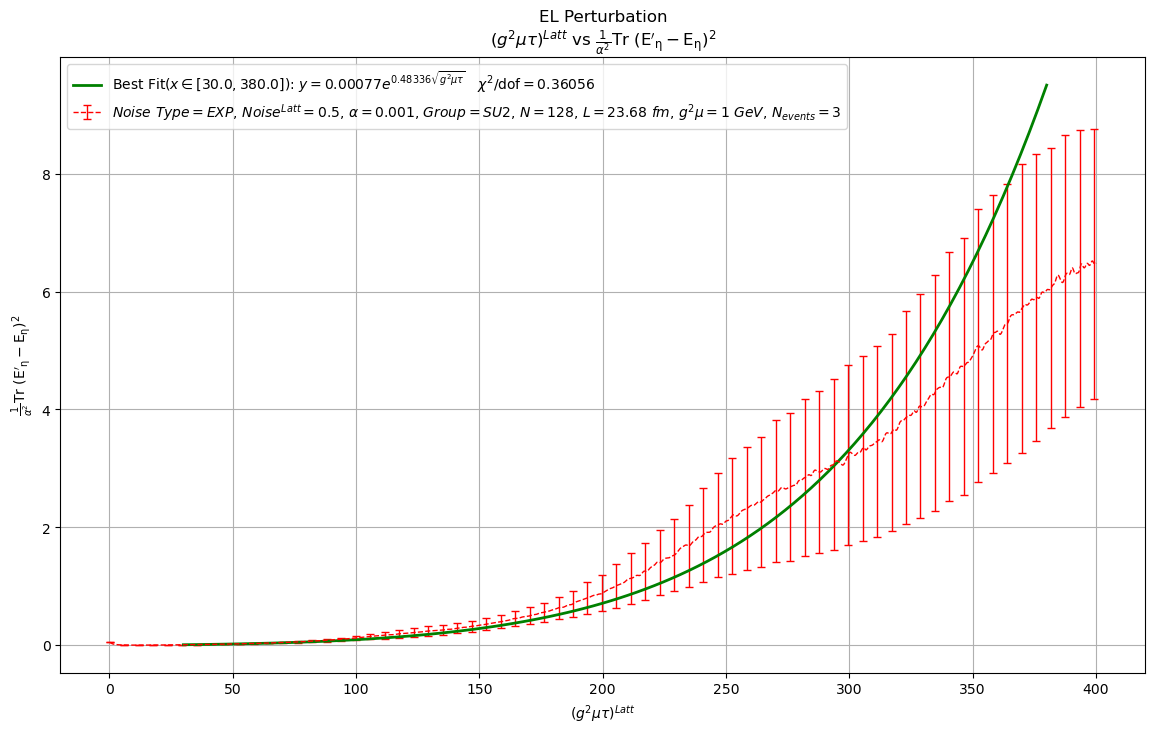

----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Processing file: Data_PerturbEL_tau_Tr_BLdiff2_by_alpha2_NoiseEXP_Noise0.5_alpha0.001_GroupSU2_N128_L23.68_g2mu1_Ntstepspera8_Nevents3.csv
Performing curve fitting for file: Data_PerturbEL_tau_Tr_BLdiff2_by_alpha2_NoiseEXP_Noise0.5_alpha0.001_GroupSU2_N128_L23.68_g2mu1_Ntstepspera8_Nevents3.csv
Best fit for Tr_BLdiff2_by_alpha2: x_min=30.0, x_max=380.0, a=6.3115e-04, b=4.9175e-01, χ²/dof=0.3580, range_x_sqrt=5.6065
Plot saved as: /home/pooja4593/Desktop/Research/curraun/Lyapunov_Output_Files_20251026/Plot_PerturbEL_Tr_BLdiff2_by_alpha2_NoiseEXP_Noise0.5_alpha0.001_GroupSU2_N128_L23.68_g2mu1_Ntstepspera8_Nevents3.png


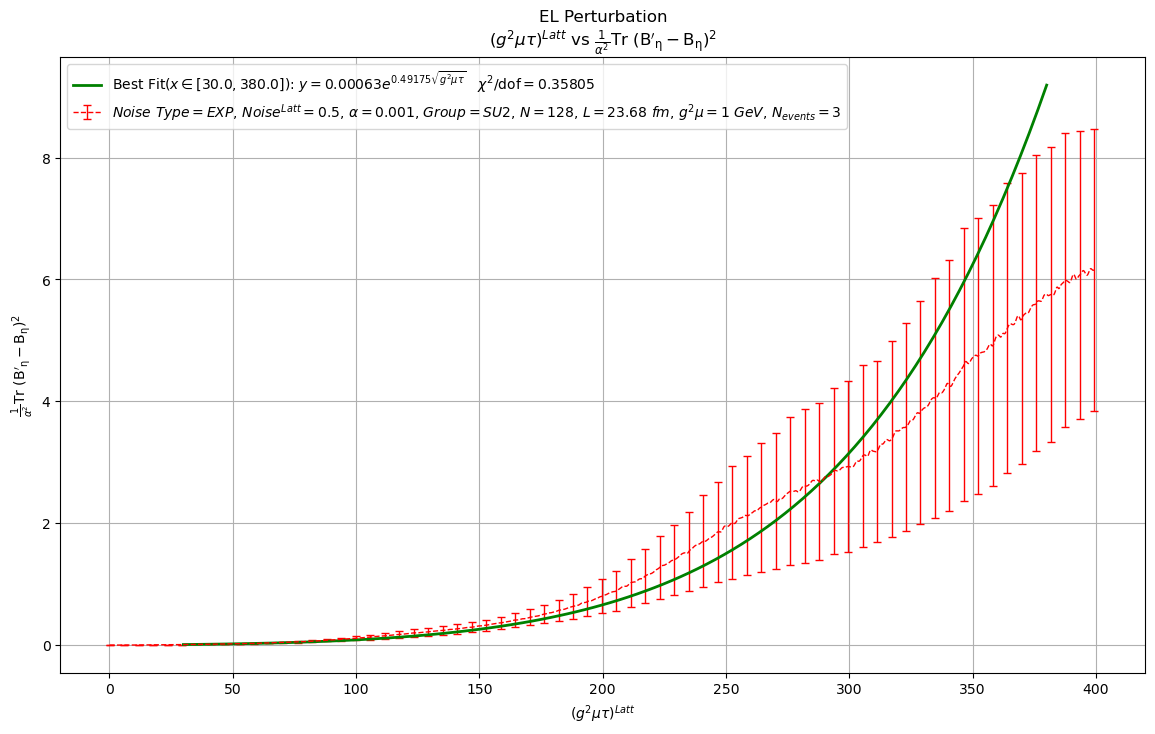

----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------

All data files saved in '/home/pooja4593/Desktop/Research/curraun/Lyapunov_Output_Files_20251026' folder, curve fitting completed, and plots generated successfully!


In [3]:
# ---------------------------------------- test cell: DELETE LATER ON ----------------------------------------
# -----------------------------------------------------------------------------------------
"""                                             SAVING, PLOTTING, CURVE FITTING ALL FILES                                             """

Current_Directory  =  os.getcwd()                                                                                   # Get the current working directory (should be curraun/notebooks)
Parent_Directory   =  os.path.dirname(Current_Directory)                                                            # Go up one level to the curraun folder
# Parent_Directory   =  os.getcwd()                                                           

Output_Directory   =  os.path.join(Parent_Directory, f"Lyapunov_Output_Files_{datetime.now().strftime('%Y%m%d')}")          # Output directory


if not os.path.exists(Output_Directory):
    os.makedirs(Output_Directory)
    print(f"Created output directory: {Output_Directory}\n")
else:
    print(f"Output directory already exists: {Output_Directory}'n")


Plot_Configurations = [             
    # (data_key, title, y_label)
    
    
    
    ("Tr_ELdiff2_by_alpha2", 
     r"$(g^2 \mu \tau)^{Latt}$ vs $\frac{1}{\alpha^2}\mathrm{Tr~(E'_{\eta} - E_{\eta})^2}$", 
     r"$\frac{1}{\alpha^2}\mathrm{Tr~(E'_{\eta} - E_{\eta})^2}$"),
    
    ("Tr_BLdiff2_by_alpha2", 
     r"$(g^2 \mu \tau)^{Latt}$ vs $\frac{1}{\alpha^2}\mathrm{Tr~(B'_{\eta} - B_{\eta})^2}$", 
     r"$\frac{1}{\alpha^2}\mathrm{Tr~(B'_{\eta} - B_{\eta})^2}$")
    
]

def Create_Dataframe(x_data, Glasma_for_y_data, data_key, N_Events):           
    
    return pd.DataFrame({
        "tau_g2mu_Latt"         :       x_data,
        f"{data_key}_Mean"      :       Glasma_for_y_data[f"{data_key}_Mean"],
        f"{data_key}_Variance"  :       Glasma_for_y_data[f"{data_key}_Variance"],
        f"{data_key}_StD"       :       Glasma_for_y_data[f"{data_key}_StD"],
        f"{data_key}_Error"     :       Glasma_for_y_data[f"{data_key}_Error"],
        "N_Events"              :       N_Events
    })


def Save_and_Reload_to_Read(df, Filename):
    Filepath = os.path.join(Output_Directory, Filename)
    df.to_csv(Filepath, index=False)
    return pd.read_csv(Filepath)

def Create_Plot(df, key, title, y_label, label_dynamic, Perturbation_Prefix, best_fit_params=None):


    # Add perturbation info to title
    if Perturbation_Prefix:
        if Perturbation_Prefix == "PerturbEL":
            title = f"EL Perturbation\n{title}"
        elif Perturbation_Prefix == "PerturbBL":
            title = f"BL Perturbation\n{title}"

    plt.figure(figsize=(14, 8))
    
    # Plot original data with error bars
    plt.errorbar(
        x           =   df["tau_g2mu_Latt"],
        y           =   df[f"{key}_Mean"],
        yerr        =   df[f"{key}_Error"],
        label       =   label_dynamic,
        errorevery  =   50,
        linewidth   =   1,
        linestyle   =   "--",
        color       =   "red",
        ecolor      =   "red",
        elinewidth  =   1,
        capsize     =   3,
        capthick    =   1
    )
    


    # Plot fitted curve if best fit parameters are provided
    if best_fit_params:

        x_min_best, x_max_best, a_best, b_best, reduced_chi_sq_best, range_x_sqrt = best_fit_params

        x_fit = np.linspace(x_min_best, x_max_best, 100)
        y_fit = exponential_fit_customized(x_fit, a_best, b_best)
        
        best_fit_label = (rf"Best Fit($x \in [{x_min_best}, {x_max_best}]$): " 
                         rf"$y = {a_best:.5f}e^{{{b_best:.5f}\sqrt{{g^2 \mu \tau}}}}$" + "   " 
                         rf"$\chi^2/\mathrm{{dof}} = {reduced_chi_sq_best:.5f}$")
        
        plt.plot(x_fit, y_fit, label=best_fit_label, linewidth=2, color="green")
    
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(r"$(g^2 \mu \tau)^{Latt}$")
    plt.legend()
    plt.grid()


    # Save the plot as PNG file
    Plot_filename = f"Plot_{Perturbation_Prefix}_{key}_{Common_Suffix}.png"
    Plot_Filepath = os.path.join(Output_Directory, Plot_filename)  

    plt.savefig(Plot_Filepath, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Plot saved as: {Plot_Filepath}")
    
    plt.show()
    plt.close()                             # Close the figure to free memory


def exponential_fit_customized(x, a, b):
    sqrt_x = np.sqrt(x)
    y = a * np.exp(b * sqrt_x)
    return y

def Perform_Curve_Fitting(df, data_key, Common_Suffix, Perturbation_Prefix=None):
    x_data = df["tau_g2mu_Latt"]
    y_data = df[f"{data_key}_Mean"]
    y_error = df[f"{data_key}_Error"]
    

    # Define the ranges to test
    x_min = np.arange(5, 101, 25)  # [5, 10, ..., 95, 100]
    x_max = np.arange(30, 405, 25)  # [50, 55, ..., 300]
    

    Curve_Fitting_Results_Table = []
    

    for x_min_fit in x_min:
        for x_max_fit in x_max:

            if x_min_fit >= x_max_fit:          # Skip invalid ranges
                continue
                                        
            #                                           Filter data in current range using mask 
            mask = (x_data >= x_min_fit) & (x_data <= x_max_fit)                            
            x_fit = x_data[mask]
            y_fit = y_data[mask]
            y_error_fit = y_error[mask]
            
            # print("x_fit: \n", x_fit, "y_fit: \n", y_fit, "y_error_fit: \n", y_error_fit)

            sigma = y_error_fit
            p0 = [0.0004, 0.01]  

            
            #                                           Perform the fit on the filtered data
            fitted_parameters, covariance_matrix = curve_fit( exponential_fit_customized, x_fit, y_fit, p0=p0, maxfev=50000, sigma=sigma, absolute_sigma=True )
            
            a, b = fitted_parameters                                                            # Get optimal parameters for fitting
            a_error, b_error = np.sqrt(np.diag(covariance_matrix))                              # Standard errors for parameters a and b
    

            #                                       Generate points for the fitted curve (only in the fitting range)
            x_fit_curve = x_fit             
            y_fit_curve = exponential_fit_customized(x_fit_curve, a, b)

            residuals = y_fit - y_fit_curve                                                     # Calculate residuals (actual_data - fitted_data)
            chi_sq    = np.sum((residuals / sigma) ** 2)                                        # Compute χ²

                
            #                                           Compute reduced χ²
            N_data_points = len(x_fit)
            N_parameters = 2
            dof = N_data_points - N_parameters
            reduced_chi_sq = chi_sq / dof
                
            #                                           Add new column for the x_range criterion
            range_x_sqrt = 0.4 * (np.sqrt(x_max_fit) - np.sqrt(x_min_fit))
                
            #                                           Store results
            Curve_Fitting_Results_Table.append({
                                    'x_min': x_min_fit,
                                    'x_max': x_max_fit,
                                    'a': a,
                                    'a_error': a_error,
                                    'b': b,
                                    'b_error': b_error,
                                    'chi_sq': chi_sq,
                                    'reduced_chi_sq': reduced_chi_sq,
                                    'range_x_sqrt': range_x_sqrt
                                })
                
    
    #                                   Create fitting results dataframe
    Curve_Fitting_Results_DF = pd.DataFrame(Curve_Fitting_Results_Table)
    
    if Curve_Fitting_Results_DF.empty:
        print(f"No successful fits for {data_key}_{Common_Suffix}")
        return None
    


    # ============================================== Best Fits ============================================== #
    # Find best fits : Keep only statistically acceptable fits for which Reduced χ² < 1.0
    Acceptable_Fits_ChiSq_DF = Curve_Fitting_Results_DF[Curve_Fitting_Results_DF["reduced_chi_sq"] < 1.0].copy()

    if Acceptable_Fits_ChiSq_DF.empty:
        print(f"No fits with reduced χ² < 1.0 for {data_key} !!! \nThink what to do now :(  ")        
        Best_Fits_DF = Curve_Fitting_Results_DF.nsmallest(1, 'reduced_chi_sq').copy()                   # Use the fit with smallest reduced chi-squared
    else:       
        Best_Fits_DF = Acceptable_Fits_ChiSq_DF.sort_values(["b_error"]).copy()  # Sort acceptable fits by b_error in ascending order


    # =========================================== Best of Best Fits =========================================== #
    # Select best fits based on the new criterion: range_x_sqrt = 0.4*(√x_max - √x_min) ≥ some_number
    some_number = 1.5    
    BestofBest_Fits_DF = Best_Fits_DF[Best_Fits_DF["range_x_sqrt"] >= some_number].copy()                   # Filter based on the new criterion    

    if BestofBest_Fits_DF.empty:
        print(f"\nNo fits satisfy all criteria (χ² < 1.0 AND 0.4*(√x_max-√x_min) ≥ {some_number} for {data_key} !!!")
        print("Using the best fit from χ² < 1.0 sorted by b_error instead.")
        BestofBest_Fits_DF = Best_Fits_DF.head(1).copy()                                                # Take the top one if none satisfy the sqrt criterion
    else:        
        BestofBest_Fits_DF = BestofBest_Fits_DF.sort_values(['b_error', 'range_x_sqrt'], ascending=[True, False])      # Sort first by b_error (ascending), then by range_x_sqrt (descending)

    BestofBest_Fits_for_Plotting =  BestofBest_Fits_DF.head(1).copy()     



    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Data files for fit results !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Save: Fit results
    Fit_All_Filename         =  f"Fits_All_{Perturbation_Prefix}_{data_key}_{Common_Suffix}.txt"
    Best_Fit_Filename        =  f"Fits_Best_{Perturbation_Prefix}_{data_key}_{Common_Suffix}.txt"
    BestofBest_Fit_Filename  =  f"Fits_BestofBest_{Perturbation_Prefix}_{data_key}_{Common_Suffix}.txt"

    # Add filepaths
    Fit_All_Filepath         =  os.path.join(Output_Directory, Fit_All_Filename)
    Best_Fit_Filepath        =  os.path.join(Output_Directory, Best_Fit_Filename)
    BestofBest_Fit_Filepath  =  os.path.join(Output_Directory, BestofBest_Fit_Filename)


    formatted_output = Curve_Fitting_Results_DF.to_string(   index=False,  justify='center',  col_space=15  )#,  float_format="%.4e"   )
    with open(Fit_All_Filepath, "w") as f:
        f.write(f"Curve Fitting Results for {data_key}\n\n")
        f.write(formatted_output)
    
    formatted_output = Best_Fits_DF.to_string(index=False, justify='center', col_space=15)
    with open(Best_Fit_Filepath, "w") as f:
        f.write(f"Best Curve Fitting Results for {data_key}\n\n")
        f.write(formatted_output)

    formatted_output = BestofBest_Fits_DF.to_string(index=False, justify='center', col_space=15)
    with open(BestofBest_Fit_Filepath, "w") as f:       
        f.write(f"Best of Best Curve Fitting Results for {data_key}\n\n")
        f.write(formatted_output)
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    
    # Extract best fit parameters
    best_fit_row = BestofBest_Fits_for_Plotting.iloc[0]
    best_params = (
        best_fit_row['x_min'],
        best_fit_row['x_max'], 
        best_fit_row['a'],
        best_fit_row['b'],
        best_fit_row['reduced_chi_sq'],
        best_fit_row['range_x_sqrt']
    )

    # print("best_params", best_params)    
    return best_params

print("**" * 80)
print("**" * 80)

if Option_Noise_Type == 0:
    label_dynamic = rf"$Noise~Type = {Noise_Type_String}$, $\alpha = {alpha_String}$, $Group = {Gauge_Group_String}$, $N = {N_T}$, $L = {L_String}~fm$, $g^2\mu = {g2mu_String}~GeV$, $N_{{events}} = {N_Events}$"
    Common_Suffix = f"Noise{Noise_Type_String}_alpha{alpha_String}_Group{Gauge_Group_String}_N{N_T}_L{L_String}_g2mu{g2mu_String}_Ntstepspera{N_TimeSteps_per_a}_Nevents{N_Events}"
    print("No noise case.\n")
elif Option_Noise_Type in [1, 2, 3]:
    label_dynamic = rf"$Noise~Type = {Noise_Type_String}$, $Noise^{{Latt}} = {Noise_Value_String}$, $\alpha = {alpha_String}$, $Group = {Gauge_Group_String}$, $N = {N_T}$, $L = {L_String}~fm$, $g^2\mu = {g2mu_String}~GeV$, $N_{{events}} = {N_Events}$"
    Common_Suffix = f"Noise{Noise_Type_String}_Noise{Noise_Value_String}_alpha{alpha_String}_Group{Gauge_Group_String}_N{N_T}_L{L_String}_g2mu{g2mu_String}_Ntstepspera{N_TimeSteps_per_a}_Nevents{N_Events}"
    print("With noise case.\n")
else:
    print(f"Error: Option_Noise_Type = {Option_Noise_Type} not recognized")   
    sys.exit(1)

if Option_Fluctuations_EL_BL in [1, 2]:
    print(f"Option_Fluctuations_EL_BL = {Option_Fluctuations_EL_BL}\n")
    
    
    # Determine perturbation type for file naming
    if Option_Fluctuations_EL_BL == 1:
        Perturbation_Prefix = "PerturbEL"
        print("Processing Electric Field Perturbations (EL) ...\n")
    elif Option_Fluctuations_EL_BL == 2:
        Perturbation_Prefix = "PerturbBL" 
        print("Processing Magnetic Field Perturbations (BL) ...\n")
    else:
        Perturbation_Prefix = "None" 
        print("No fluctautions provided, PLEASE CHECK AGAIN !!! \n")



    best_fit_parameters = {}                                                                            # Dictionary to store best fit parameters for each data key
    
    for data_key, title, y_label in Plot_Configurations:

        Filename = f"Data_{Perturbation_Prefix}_tau_{data_key}_{Common_Suffix}.csv"                     # Generate Filename
        print(f"Processing file: {Filename}")
                
        df = Create_Dataframe(tau_g2mu_Latt, Glasma, data_key, N_Events)                                # Create DataFrame
        df = Save_and_Reload_to_Read(df, Filename)                                                      # Save DataFrame   
        
        print(f"Performing curve fitting for file: {Filename}")
        best_params = Perform_Curve_Fitting(df, data_key, Common_Suffix, Perturbation_Prefix)                                # Perform curve fitting
        

        if best_params:
            best_fit_parameters[data_key] = best_params
            print(f"Best fit for {data_key}: x_min={best_params[0]}, x_max={best_params[1]}, a={best_params[2]:.4e}, b={best_params[3]:.4e}, χ²/dof={best_params[4]:.4f}, range_x_sqrt={best_params[5]:.4f}")
            
            Create_Plot(df, data_key, title, y_label, label_dynamic, Perturbation_Prefix, best_params)                      # Create plot with original data and fitted curve

        else:
            print(f"Could not find good fit for {data_key}")            
            Create_Plot(df, data_key, title, y_label, label_dynamic, Perturbation_Prefix, None)                             # Create plot without fitted curve
        
        print("--" * 80)
        print("--" * 80)
       
    print(f"\nAll data files saved in '{Output_Directory}' folder, curve fitting completed, and plots generated successfully!")
    
else:
    print(f"Error: Option_Fluctuations_EL_BL = {Option_Fluctuations_EL_BL} not recognized")
    sys.exit(1)
